In [6]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [38]:
import pickle
from pyscf import gto, scf, dft, cc
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from FcMole import *
import os
import ast
from IPython.display import display

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset ##

In [8]:
# Load the dataset
total_energy_data = np.load('../Data/Benzene_BNdoping_PBE0_pcX2_opt.npz', allow_pickle=True)
electronic_energy_data = np.load('../Data/Benzene_BNdoping_PBE0_pcX2_electronic_opt.npz', allow_pickle=True)

# Unpack the data into numpy arrays
charges, coords, elements, total_energy, electronic_energy = total_energy_data['charges'], total_energy_data['coords'], total_energy_data['elements'], total_energy_data['energies'], electronic_energy_data['energies']


In [9]:
# Understand the dimension of the data

print(charges.shape) # (17, 12)
print(coords.shape) # (17, 12, 3)
print(elements.shape) # (17, 12)
print(total_energy.shape) # (17,)
print(electronic_energy.shape) #(17,)

(17, 12)
(17, 12, 3)
(17, 12)
(17,)
(17,)


In [10]:
# Creating pandas dataframe for the data

columns = ['charges', 'elements', 'total energy', 'electronic energy']
benzene_data = pd.DataFrame(columns=columns)

benzene_data['charges'] = charges.tolist()
benzene_data['elements'] = elements.tolist()
benzene_data['total energy'] = total_energy.tolist()
benzene_data['electronic energy'] = electronic_energy.tolist()
display(benzene_data)

,charges,elements,total energy,electronic energy
0,"[7, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, B, C, C, C, C, H, H, H, H, H, H]",-230.034644,-336.906006
1,"[7, 6, 5, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, B, C, C, C, H, H, H, H, H, H]",-230.040119,-336.995987
2,"[7, 6, 6, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, C, B, C, C, H, H, H, H, H, H]",-230.032860,-337.004116
3,"[7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, B, C, C, H, H, H, H, H, H]",-233.459886,-340.400298
4,"[7, 7, 5, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, C, B, C, H, H, H, H, H, H]",-233.463021,-340.318992
5,"[7, 7, 5, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, N, B, C, C, B, H, H, H, H, H, H]",-233.453088,-340.193778
6,"[7, 7, 6, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, C, B, B, C, H, H, H, H, H, H]",-233.470031,-340.510269
7,"[7, 5, 7, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, B, N, C, C, B, H, H, H, H, H, H]",-233.464654,-340.067245
8,"[7, 5, 7, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, B, N, C, B, C, H, H, H, H, H, H]",-233.470116,-340.126176
9,"[7, 6, 7, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, C, N, B, B, C, H, H, H, H, H, H]",-233.469772,-340.325617


## ANM Calculation ##

### DFT Calculation ###

In [39]:
def get_DFT(benz_atom, basis):
    
    if os.path.isfile('../Data/benz_DFT.pkl'):
        with open("../Data/benz_DFT.pkl", "rb") as file:
            benz_DFT = pickle.load(file)
    else:
        mol_benz=gto.M(atom=benz_atom, basis=basis, unit='Angstrom')
        # run DFT calculation
        benz_DFT = scf.RKS(mol_benz)
        benz_DFT.xc = "PBE0" # specify the exchange-correlation functional used for DFT
        benz_DFT.kernel() # run self-consistent field calculation
        with open("../Data/benz_DFT.pkl", "wb") as file:
            pickle.dump(benz_DFT, file)

    benz_total_energy = benz_DFT.energy_tot()
    benz_electronic_energy = benz_DFT.energy_elec()

    return benz_DFT, benz_total_energy, benz_electronic_energy

In [11]:
# Specify the atomic coordinates of benzene molecule (the reference molecule for ANM calculations)

benz_atom="""
C        3.22272669       0.22711285       0.00013582
C        5.87141753       0.22698034       0.00094988
C        7.19597908       2.52071412      -0.00011471
C        5.87164800       4.81458054      -0.00200817
C        3.22295713       4.81471307      -0.00280461
C        1.89839559       2.52097926      -0.00174231
H        2.18773340      -1.56549239       0.00096741
H        6.90623079      -1.56572844       0.00241360
H        9.26591446       2.52061061       0.00051784
H        6.90664130       6.60718579      -0.00284841
H        2.18814386       6.60742187      -0.00426425
H       -0.17153979       2.52108280      -0.00237226
"""

In [12]:
# Specify the basis used: pcx2

basis_pcx2={"H":"pc-2",'C':bse.get_basis("pcX-2",fmt="nwchem",elements=[6])\
           ,'N':bse.get_basis("pcX-2",fmt="nwchem",elements=[7])\
           ,'O':bse.get_basis("pcX-2",fmt="nwchem",elements=[8])}

In [13]:
# create molecule
mol_benz=gto.M(atom=benz_atom, basis=basis_pcx2, unit='Angstrom')

# run DFT calculation
benz_DFT = scf.RKS(mol_benz)
benz_DFT.xc = "PBE0" # specify the exchange-correlation functional used for DFT
benz_DFT.kernel() # run self-consistent field calculation

converged SCF energy = -229.912170593055


-229.9121705930553

In [14]:
# Calculate the total and electronic energy

benz_total_energy = benz_DFT.energy_tot()
benz_electronic_energy = benz_DFT.energy_elec()

print("Total energy:", benz_total_energy)
print("Electronic energy:", benz_electronic_energy) #(electronic energy, nuclear repulsion energy)

# Total energy: -229.91217059305342
# Electronic energy: (-336.9833214880193, 181.97988746354838)

Total energy: -229.91217059305302
Electronic energy: (-336.983321488019, 181.97988730624468)


In [15]:
print(type(benz_DFT))

<class 'pyscf.dft.rks.RKS'>


In [16]:
benzene_data['delta total energy'] = benzene_data['total energy'].apply(lambda x: benz_total_energy - x)
benzene_data['delta electronic energy'] = benzene_data['electronic energy'].apply(lambda x: benz_electronic_energy[0] - x)
display(benzene_data)

,charges,elements,total energy,electronic energy,delta total energy,delta electronic energy
0,"[7, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, B, C, C, C, C, H, H, H, H, H, H]",-230.034644,-336.906006,0.122473,-0.077315
1,"[7, 6, 5, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, B, C, C, C, H, H, H, H, H, H]",-230.040119,-336.995987,0.127949,0.012665
2,"[7, 6, 6, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, C, B, C, C, H, H, H, H, H, H]",-230.032860,-337.004116,0.120689,0.020794
3,"[7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, B, C, C, H, H, H, H, H, H]",-233.459886,-340.400298,3.547716,3.416976
4,"[7, 7, 5, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, C, B, C, H, H, H, H, H, H]",-233.463021,-340.318992,3.550851,3.335670
5,"[7, 7, 5, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, N, B, C, C, B, H, H, H, H, H, H]",-233.453088,-340.193778,3.540918,3.210456
6,"[7, 7, 6, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, C, B, B, C, H, H, H, H, H, H]",-233.470031,-340.510269,3.557860,3.526948
7,"[7, 5, 7, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, B, N, C, C, B, H, H, H, H, H, H]",-233.464654,-340.067245,3.552483,3.083924
8,"[7, 5, 7, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, B, N, C, B, C, H, H, H, H, H, H]",-233.470116,-340.126176,3.557946,3.142854
9,"[7, 6, 7, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, C, N, B, B, C, H, H, H, H, H, H]",-233.469772,-340.325617,3.557601,3.342296


### Hessian and ANM ###

In [17]:
# Load the Hessian

def get_hessian(DFT):
    """ 
    Load the energy hessian matrix of the specified molecule with respect to its nuclear charges
    
    Args:
        DFT (pyscf.dft.rks.RKS object): the DFT RKS object of the molecule in question
    
    Returns:
        H (ndarray): The hessian matrix of the molecule
    """

    if os.path.isfile('hessian_PBE0.txt'):
        H = np.loadtxt('hessian_PBE0.txt')
    else:
        C_idxs = [0, 1, 2, 3, 4, 5]
        benz_ap=AP(DFT, sites=C_idxs)
        H = benz_ap.build_hessian()
    return H

In [18]:
# Get the Hessian

H = get_hessian(benz_DFT)
print(H)


[[-3.37583818  0.16302604  0.15061107  0.13936407  0.16491505  0.14365052]
 [ 0.16302604 -3.37583589  0.14365083  0.16491407  0.13936633  0.15060779]
 [ 0.15061107  0.14365083 -3.40105126  0.14365107  0.1506074   0.19166145]
 [ 0.13936407  0.16491407  0.14365107 -3.37583742  0.16302608  0.15061038]
 [ 0.16491505  0.13936633  0.1506074   0.16302608 -3.37583547  0.14365075]
 [ 0.14365052  0.15060779  0.19166145  0.15061038  0.14365075 -3.40104752]]


In [19]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q)
print(Q_inv)
print(epsilon)

[[-4.09259973e-01 -6.06256052e-02  5.00021152e-01  2.87226831e-01
   4.99965083e-01  4.96331866e-01]
 [-4.09260235e-01  6.05875481e-02 -4.99980480e-01  2.87228132e-01
   5.00047997e-01 -4.96292987e-01]
 [-4.06216373e-01  7.01905379e-01 -1.40384008e-05 -5.78764360e-01
   1.12864525e-06  8.57257964e-02]
 [-4.09259834e-01  6.05964964e-02  5.00007350e-01  2.87201859e-01
  -4.99964170e-01 -4.96364809e-01]
 [-4.09260672e-01 -6.05777450e-02 -4.99991015e-01  2.87298223e-01
  -5.00022744e-01  4.96268084e-01]
 [-4.06217532e-01 -7.01883841e-01 -4.20414255e-05 -5.78798226e-01
  -2.71244329e-05 -8.56679749e-02]]
[[-4.09259973e-01 -4.09260235e-01 -4.06216373e-01 -4.09259834e-01
  -4.09260672e-01 -4.06217532e-01]
 [-6.06256052e-02  6.05875481e-02  7.01905379e-01  6.05964964e-02
  -6.05777450e-02 -7.01883841e-01]
 [ 5.00021152e-01 -4.99980480e-01 -1.40384008e-05  5.00007350e-01
  -4.99991015e-01 -4.20414255e-05]
 [ 2.87226831e-01  2.87228132e-01 -5.78764360e-01  2.87201859e-01
   2.87298223e-01 -5.787

In [29]:
Q_df = pd.DataFrame(Q)
display(Q_df)

# Compute the norm of each column
norms = np.linalg.norm(Q_df, axis=0)

# Display the norms
for column, norm in zip(Q_df.columns, norms):
    print(f"Norm of vector {column+1}: {norm}")

,0,1,2,3,4,5
0,-0.409260,-0.060626,0.500021,0.287227,0.499965,0.496332
1,-0.409260,0.060588,-0.499980,0.287228,0.500048,-0.496293
2,-0.406216,0.701905,-0.000014,-0.578764,0.000001,0.085726
3,-0.409260,0.060596,0.500007,0.287202,-0.499964,-0.496365
4,-0.409261,-0.060578,-0.499991,0.287298,-0.500023,0.496268
5,-0.406218,-0.701884,-0.000042,-0.578798,-0.000027,-0.085668


Norm of vector 1: 1.0
Norm of vector 2: 0.9999999999999999
Norm of vector 3: 1.0
Norm of vector 4: 1.0000000000000002
Norm of vector 5: 1.0
Norm of vector 6: 0.9999999999999999


In [31]:
Q_inv_df = pd.DataFrame(Q_inv)
display(Q_inv_df)

# Compute the norm of each column
norms = np.linalg.norm(Q_inv_df, axis=0)

# Display the norms
for column, norm in zip(Q_inv_df.columns, norms):
    print(f"Norm of vector {column+1}: {norm}")

,0,1,2,3,4,5
0,-0.409260,-0.409260,-0.406216,-0.409260,-0.409261,-0.406218
1,-0.060626,0.060588,0.701905,0.060596,-0.060578,-0.701884
2,0.500021,-0.499980,-0.000014,0.500007,-0.499991,-0.000042
3,0.287227,0.287228,-0.578764,0.287202,0.287298,-0.578798
4,0.499965,0.500048,0.000001,-0.499964,-0.500023,-0.000027
5,0.496332,-0.496293,0.085726,-0.496365,0.496268,-0.085668


Norm of vector 1: 0.9999999999999751
Norm of vector 2: 1.0000000000000153
Norm of vector 3: 0.9999999999999958
Norm of vector 4: 0.9999999999999809
Norm of vector 5: 1.0000000000000284
Norm of vector 6: 1.0000000000000036


## Data Transformation ##

### Feature Transformation ###

In [25]:
def lexi_transformation(arr):
    """ 
    This function maps cyclic arrays that are rotational or reflectional identical onto the same vector.
    The function iterate through all rotaional and reflectional variants of the array,
    and select the lexicographically minimum array as the final representation.

    Args:
        arr (ndarray): a numpy array to be transformed
    
    Return:
        transformed_arr (ndarray): transformed array
    """
    
    # Create all possible rotations of the cycle
    shift = np.arange(len(arr))

    shifted_arrays = []
    for s in shift:
        shifted = np.roll(arr, shift=s)
        shifted_arrays.append(shifted)
    
    rotations = np.vstack(shifted_arrays)

    # Create the corresponding reverse traversal patterns for each rotation
    reverse_traversals = np.flip(rotations, axis=1)

    # Combine rotations and reverse traversals
    all_patterns = np.vstack((rotations, reverse_traversals))

    # Find the lexicographically smallest representation (left to right)
    sorted_indices = np.lexsort(all_patterns.T[::-1])
    min_pattern = all_patterns[sorted_indices[0]]
    
    # Return the lexicographically smallest pattern as the vector representation
    return min_pattern

In [26]:
def lexi_transformation_2d(arr):
    transformed_arr = []
    
    for row in arr:
        transformed_row = lexi_transformation(row)
        transformed_arr.append(transformed_row)
    
    return np.array(transformed_arr)

In [27]:
def lexi_and_opposite_transformation(arr):
    """ 
    This function maps cyclic arrays that are rotational identical, reflectional identical, 
    or opposite onto the same vector.
    The function iterate through all rotaional, reflectional, and opposite variants of the array,
    and select the lexicographically minimum array as the final representation.

    Args:
        arr (ndarray): a numpy array to be transformed
    
    Return:
        transformed_arr (ndarray): transformed array
    """
    
    # Create all possible rotations of the cycle
    shift = np.arange(len(arr))

    shifted_arrays = []
    for s in shift:
        shifted = np.roll(arr, shift=s)
        shifted_arrays.append(shifted)
    
    rotations = np.vstack(shifted_arrays)

    # Create the corresponding reverse traversal patterns for each rotation
    reverse_traversals = np.flip(rotations, axis=1)

    # Combine rotations and reverse traversals
    all_patterns = np.vstack((rotations, reverse_traversals))
    
    # Negate existing vectors 
    all_patterns_neg = -all_patterns

    # Combing the negated vectors with the original
    all_patterns = np.vstack((all_patterns, all_patterns_neg))

    # Find the lexicographically smallest representation (left to right)
    sorted_indices = np.lexsort(all_patterns.T[::-1])
    min_pattern = all_patterns[sorted_indices[0]]
    
    # Return the lexicographically smallest pattern as the vector representation
    return min_pattern

In [28]:
def lexi_and_opposite_transformation_2d(arr):
    transformed_arr = []
    
    for row in arr:
        transformed_row = lexi_and_opposite_transformation(row)
        transformed_arr.append(transformed_row)
    
    return np.array(transformed_arr)

### Calculating dx and c ###

In [34]:
# Compute the dx value as the different between target charge and reference charge
ref_charge = [6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]
ref_charge_array = np.tile(ref_charge, (17, 1))
target_charge_array = np.array(benzene_data['charges'].tolist())
dx_array = (target_charge_array - ref_charge_array)[:, :6] # only take the dx for C atoms


# try different ways to sort the dx vector
sorted_dx_array = np.sort(dx_array, axis=1) # sorted dx elements
lexi_dx_array = lexi_transformation_2d(dx_array) # rotational and reflectional invariant


# Compute the c array, which represents the ANM coordinates
c_array = (Q @ dx_array.T).T
sorted_c_array = (Q @ sorted_dx_array.T).T
lexi_c_array = (Q @ lexi_dx_array.T).T

inv_c_array = (Q_inv @ dx_array.T).T
inv_sorted_c_array = (Q_inv @ sorted_dx_array.T).T
inv_lexi_c_array = (Q_inv @ lexi_dx_array.T).T

# Append the data onto the dataframe
benzene_data['dx'] = dx_array.tolist()
benzene_data['sorted_dx'] = sorted_dx_array.tolist()
benzene_data['lexi_dx'] = lexi_dx_array.tolist()

benzene_data['c'] = c_array.tolist()
benzene_data['sorted_c'] = sorted_c_array.tolist()
benzene_data['lexi_c'] = lexi_c_array.tolist()

benzene_data['inv_c'] = inv_c_array.tolist()
benzene_data['inv_sorted_c'] = inv_sorted_c_array.tolist()
benzene_data['inv_lexi_c'] = inv_lexi_c_array.tolist()

benzene_data['num_dope'] = benzene_data['dx'].apply(lambda my_list: sum(1 for elem in my_list if elem != 0))

dx_columns = ['dx', 'sorted_dx', 'lexi_dx', 'num_dope']
c_columns = ['c', 'sorted_c', 'lexi_c']
inv_c_columns = ['inv_c', 'inv_sorted_c', 'inv_lexi_c']

display(benzene_data[dx_columns])
display(benzene_data[c_columns].head())
display(benzene_data[inv_c_columns].head())

,dx,sorted_dx,lexi_dx,num_dope
0,"[1, -1, 0, 0, 0, 0]","[-1, 0, 0, 0, 0, 1]","[-1, 0, 0, 0, 0, 1]",2
1,"[1, 0, -1, 0, 0, 0]","[-1, 0, 0, 0, 0, 1]","[-1, 0, 0, 0, 1, 0]",2
2,"[1, 0, 0, -1, 0, 0]","[-1, 0, 0, 0, 0, 1]","[-1, 0, 0, 1, 0, 0]",2
3,"[1, 1, -1, -1, 0, 0]","[-1, -1, 0, 0, 1, 1]","[-1, -1, 0, 0, 1, 1]",4
4,"[1, 1, -1, 0, -1, 0]","[-1, -1, 0, 0, 1, 1]","[-1, 0, -1, 0, 1, 1]",4
5,"[1, 1, -1, 0, 0, -1]","[-1, -1, 0, 0, 1, 1]","[-1, 0, 0, -1, 1, 1]",4
6,"[1, 1, 0, -1, -1, 0]","[-1, -1, 0, 0, 1, 1]","[-1, -1, 0, 1, 1, 0]",4
7,"[1, -1, 1, 0, 0, -1]","[-1, -1, 0, 0, 1, 1]","[-1, 0, 0, 1, -1, 1]",4
8,"[1, -1, 1, 0, -1, 0]","[-1, -1, 0, 0, 1, 1]","[-1, 0, 1, -1, 1, 0]",4
9,"[1, 0, 1, -1, -1, 0]","[-1, -1, 0, 0, 1, 1]","[-1, -1, 0, 1, 0, 1]",4


,c,sorted_c,lexi_c
0,"[-0.3486343676945661, -0.4698477829756595, -1....","[0.9055918394132391, -0.08703275262231841, 0.4...","[0.9055918394132391, -0.08703275262231841, 0.4..."
1,"[-0.909281124499923, 0.0907202455492569, -0.40...","[0.9055918394132391, -0.08703275262231841, 0.4...","[0.9092250563533839, 0.9093082318581963, 0.406..."
2,"[-0.696486803535665, -0.6964883666279211, 0.17...","[0.9055918394132391, -0.08703275262231841, 0.4...","[0.696486803535665, 0.6964883666279211, -0.172..."
3,"[-1.2571335603410219, -0.1359203381030047, 0.8...","[1.4661825280720568, 0.35242769626021847, -0.2...","[1.4661825280720568, 0.35242769626021847, -0.2..."
4,"[-1.469871813158741, -0.34874020333327993, 0.2...","[1.4661825280720568, 0.35242769626021847, -0.2...","[0.9055357712666998, 0.9129957247851346, 0.491..."


,inv_c,inv_sorted_c,inv_lexi_c
0,"[2.6190517748991837e-07, -0.12121315337595676,...","[0.003042440870520857, -0.6412582352904221, -0...","[0.003042440870520857, -0.6412582352904221, -0..."
1,"[-0.0030435995832050478, -0.7625309840746806, ...","[0.003042440870520857, -0.6412582352904221, -0...","[-6.987121025092691e-07, 4.78602190818328e-05,..."
2,"[-1.3856579200721697e-07, -0.12122210162011998...","[0.003042440870520857, -0.6412582352904221, -0...","[1.3856579200721697e-07, 0.12122210162011998, ..."
3,"[-0.0030440000541746004, -0.7625399323188438, ...","[0.0030420040635958934, -0.7624235284472971, -...","[0.0030420040635958934, -0.7624235284472971, -..."
4,"[-0.003043162776280084, -0.6413656909178056, 0...","[0.0030420040635958934, -0.7624235284472971, -...","[-1.8574247866443017e-06, -1.4037413591460208,..."


In [36]:
print(benzene_data.columns)

Index(['charges', 'elements', 'total energy', 'electronic energy',
       'delta total energy', 'delta electronic energy', 'sorted_dx', 'lexi_dx',
       'dx', 'c', 'sorted_c', 'lexi_c', 'inv_c', 'inv_sorted_c', 'inv_lexi_c',
       'num_dope'],
      dtype='object')


In [37]:
benzene_data.to_csv('../Data/benzene_training_data.csv', index=True)

## Regression ##

In [35]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import warnings

### Prepare training data ###

In [91]:
# Datasets:

# _sorted: sorted c coordinates
# _lexi: c coordinates with lexicographical mapping
# _inv: use Q_inv instead of Q
# _nd: include the number of doping
# _concat: concatinated sorted with lexi

# _delta_tot: total energy
# _delta_elec: electronic energy

In [76]:
# Extract the coordinates as six separate features


columns = [f"coord{i}" for i in range(6)]

X = pd.DataFrame(columns=columns)
X_sorted = pd.DataFrame(columns=columns)
X_lexi = pd.DataFrame(columns=columns)

num_dope = benzene_data['num_dope']

X_inv = pd.DataFrame(columns=columns)
X_inv_sorted = pd.DataFrame(columns=columns)
X_inv_lexi = pd.DataFrame(columns=columns)

for i in range(6):
    X[f"coord{i}"] = benzene_data['c'].apply(lambda x: x[i] * 10)
    X_sorted[f"coord{i}"] = benzene_data['sorted_c'].apply(lambda x: x[i] * 10)
    X_lexi[f"coord{i}"] = benzene_data['lexi_c'].apply(lambda x: x[i] * 10)
    X_inv[f"coord{i}"] = benzene_data['inv_c'].apply(lambda x: x[i] * 10)
    X_inv_sorted[f"coord{i}"] = benzene_data['inv_sorted_c'].apply(lambda x: x[i] * 10)
    X_inv_lexi[f"coord{i}"] = benzene_data['inv_lexi_c'].apply(lambda x: x[i] * 10)

X_lexi_nd = pd.concat([X_lexi, num_dope.rename('num_dope')], axis=1)
X_inv_lexi_nd = pd.concat([X_lexi, num_dope.rename('num_dope')], axis=1)
X_nd = pd.concat([X, num_dope.rename('num_dope')], axis=1)
X_inv_nd = pd.concat([X_inv, num_dope.rename('num_dope')], axis=1)
X_concat = pd.concat([X_sorted.add_suffix('_sorted'), X_lexi], axis=1)

# Extract the targets
y_energy = benzene_data['total energy']
y_elec = benzene_data['electronic energy']
y_delta_energy = benzene_data['delta total energy']
y_delta_elec = benzene_data['delta electronic energy']

datasets = [X, X_sorted, X_lexi, X_inv, X_inv_sorted, X_inv_lexi, X_lexi_nd, X_inv_lexi_nd, X_nd, X_inv_nd]

In [71]:
# Save data to csv

for dataset in datasets:
    variable_name = [k for k, v in locals().items() if v is dataset][0]  # Get the variable name
    csv_filename = f"../Data/[Benz] {variable_name}.csv"  # Create the CSV file name
    dataset.to_csv(csv_filename, index=False)  # Save the dataframe as CSV

y_energy.to_csv('../Data/[Benz] y_energy.csv', index=False)
y_elec.to_csv('../Data/[Benz] y_elec.csv', index=False)
y_delta_energy.to_csv('../Data/[Benz] y_delta_energy.csv', index=False)
y_delta_elec.to_csv('../Data/[Benz] y_delta_elec.csv', index=False)

In [82]:
# Try concating X_sorted and X_lexi

X_concat = pd.concat([X_sorted.add_suffix('_sorted'), X_lexi], axis=1)
X_concat.to_csv(f"../Data/[Benz] X_concat.csv", index=False)

### Polynomial Kernel ###

In [83]:
params = {'alpha': 3.4835443037974683e-13, 'coef0': 0.0024369823529411766, 'degree': 2, 'kernel': 'poly'}
KRR_model = KernelRidge(**params)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mse_scores = cross_val_score(KRR_model, X_concat, y_delta_energy, scoring='neg_mean_squared_error', cv=k_fold)
    rmse_scores = np.sqrt(-mse_scores)  

# Calculate the average error across all folds
avg_rmse = rmse_scores.mean()

# Print the mean squared error for each fold
print("Polynomial KRR:")
for fold, rmse in enumerate(rmse_scores):
    print(f"Fold {fold+1}: RMSE = {rmse}")

# Print the average mean squared error
print(f"Average RMSE across all folds: {avg_rmse}")

Polynomial KRR:
Fold 1: RMSE = 0.2952768647515528
Fold 2: RMSE = 0.42910061212011485
Fold 3: RMSE = 1.3749995561505928
Fold 4: RMSE = 0.4056344549981104
Fold 5: RMSE = 0.20531351910443352
Average RMSE across all folds: 0.5420650014249608


### Gaussian Kernel ###

In [92]:
params = {'alpha': 1.5306122448979593e-09, 'gamma': 2.2857142857142856e-06, 'kernel': 'rbf'}
KRR_model = KernelRidge(**params)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(KRR_model, X_lexi, y_delta_energy, scoring='neg_mean_squared_error', cv=k_fold)
rmse_scores = np.sqrt(-mse_scores)

# Calculate the average error across all folds
avg_rmse = rmse_scores.mean()

# Print the mean squared error for each fold
print("Polynomial KRR:")
for fold, rmse in enumerate(rmse_scores):
    print(f"Fold {fold+1}: RMSE = {rmse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_rmse}")

Polynomial KRR:
Fold 1: RMSE = 0.18241370474651017
Fold 2: RMSE = 2.4870798414960444
Fold 3: RMSE = 2.330903067806286
Fold 4: RMSE = 0.08637292474859333
Fold 5: RMSE = 0.03516010103785058
Average MSE across all folds: 1.0243859279670569


### Linear Ridge Regression ###

In [109]:
liear_model = Ridge(alpha=1)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(liear_model, X_lexi_nd, y_delta_energy, scoring='neg_mean_squared_error', cv=k_fold)
rmse_scores = np.sqrt(-mse_scores)  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_rmse = rmse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: RMSE = {rmse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_rmse}")

Fold 1: RMSE = 0.03516010103785058
Fold 2: RMSE = 0.03516010103785058
Fold 3: RMSE = 0.03516010103785058
Fold 4: RMSE = 0.03516010103785058
Fold 5: RMSE = 0.03516010103785058
Average MSE across all folds: 0.18901327839066934


## Model Prediction and Learning Curve ##

In [62]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_val, y_pred) 
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)/np.sqrt(num_trials)
    return average_error, std_dev_error

### Polynomial Kernel ###

In [94]:
# Poly_lexi_delta_tot

best_params = {'alpha': 3.4835443037974683e-13, 'coef0': 0.0024369823529411766, 'degree': 2, 'kernel': 'poly'}
model_poly_lexi_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_poly_lexi_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_poly_lexi_delta_tot, X_lexi, y_delta_energy, num_training_sample, num_trials)
        model_performance_poly_lexi_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_poly_lexi_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_poly_lexi_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_poly_lexi_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2300.789955,78.003873
2,4,1962.530018,110.388085
3,8,1512.016298,127.810845
4,16,270.434796,128.813874


In [96]:
# Poly_lexi_nd_delta_tot

best_params = {'alpha': 1e-13, 'coef0': 6.04e-06, 'degree': 2, 'kernel': 'poly'}
model_poly_lexi_nd_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_poly_lexi_nd_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_poly_lexi_nd_delta_tot, X_lexi_nd, y_delta_energy, num_training_sample, num_trials)
        model_performance_poly_lexi_nd_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_poly_lexi_nd_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_poly_lexi_nd_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_poly_lexi_nd_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2262.735037,79.918537
2,4,1917.247227,113.285183
3,8,1465.296152,126.229849
4,16,315.376659,120.075848


In [124]:
# Poly_sorted_delta_tot

best_params = {'alpha': 7.969230769230769e-13, 'coef0': 3.9076923076923075e-05, 'degree': 2, 'kernel': 'poly'}
model_poly_sorted_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_poly_sorted_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_poly_sorted_delta_tot, X_sorted, y_delta_energy, num_training_sample, num_trials)
        model_performance_poly_sorted_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_poly_sorted_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_poly_sorted_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_poly_sorted_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,481.365856,72.213214
2,4,418.898595,89.904617
3,8,84.864144,55.499088
4,16,10.639693,2.114254


### Gaussian Kernel ###

In [98]:
# Gaussian_lexi_delta_tot

best_params = {'alpha': 1e-17, 'gamma': 2e-07, 'kernel': 'rbf'}
model_gaussian_lexi_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi_delta_tot, X_lexi, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_lexi_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2091.084169,140.344
2,4,3083.240531,325.925402
3,8,2302.737071,253.780736
4,16,249.158003,163.398899


In [104]:
# Gaussian_lexi_nd_delta_tot

best_params = {'alpha': 1.5306122448979593e-9, 'gamma': 2.2857142857142856e-06, 'kernel': 'rbf'}
model_gaussian_lexi_nd_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_lexi_nd_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_lexi_nd_delta_tot, X_lexi_nd, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_lexi_nd_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_lexi_nd_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_lexi_nd_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_lexi_nd_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2065.959865,134.883801
2,4,2916.521003,283.97475
3,8,78.294414,15.755746
4,16,9.311864,0.836114


In [115]:
# Gaussian_sorted_delta_tot

best_params = {'alpha': 1e-05, 'gamma': 1.5998587196060572e-05, 'kernel': 'rbf'}
model_gaussian_sorted_delta_tot = KernelRidge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_gaussian_sorted_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_gaussian_sorted_delta_tot, X_sorted, y_delta_energy, num_training_sample, num_trials)
        model_performance_gaussian_sorted_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_gaussian_sorted_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_gaussian_sorted_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_gaussian_sorted_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,929.632934,86.580223
2,4,755.961765,129.575923
3,8,124.466197,76.034637
4,16,10.406633,2.113336


### Linear Model ###

In [113]:
# linear_lexi_delta_tot

best_params = {'alpha': 219}
model_linear_lexi_delta_tot = Ridge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_linear_lexi_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_linear_lexi_delta_tot, X_lexi, y_delta_energy, num_training_sample, num_trials)
        model_performance_linear_lexi_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_linear_lexi_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_linear_lexi_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_linear_lexi_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,1856.374395,100.287906
2,4,1946.279804,96.420172
3,8,1907.539467,99.034697
4,16,1536.305401,255.569351


In [110]:
# linear_lexi_nd_delta_tot

best_params = {'alpha': 0.0367}
model_linear_lexi_nd_delta_tot = Ridge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_linear_lexi_nd_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_linear_lexi_nd_delta_tot, X_lexi_nd, y_delta_energy, num_training_sample, num_trials)
        model_performance_linear_lexi_nd_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_linear_lexi_nd_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_linear_lexi_nd_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_linear_lexi_nd_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,2065.738844,135.012394
2,4,2917.607538,284.414079
3,8,46.743384,10.740132
4,16,15.397039,1.399329


In [122]:
# linear_sorted_delta_tot

best_params = {'alpha': 0.002}
model_linear_sorted_delta_tot = Ridge(**best_params)

columns = ['training size', 'average MAE (mHa)', 'standard deviation (mHa)']
model_performance_linear_sorted_delta_tot = pd.DataFrame(columns=columns)

training_size = [2**i for i in range(1, 5)]
num_trials = 20

with warnings.catch_warnings():
    for index, num_training_sample in enumerate(training_size):
        warnings.filterwarnings("ignore")
        index = index + 1
        average_error, std_dev_error = evaluate_performance(model_linear_sorted_delta_tot, X_sorted, y_delta_energy, num_training_sample, num_trials)
        model_performance_linear_sorted_delta_tot.at[index, 'training size'] = num_training_sample
        model_performance_linear_sorted_delta_tot.at[index, 'average MAE (mHa)'] = average_error * 1000
        model_performance_linear_sorted_delta_tot.at[index, 'standard deviation (mHa)'] = std_dev_error * 1000

display(model_performance_linear_sorted_delta_tot)

,training size,average MAE (mHa),standard deviation (mHa)
1,2,929.707008,86.584112
2,4,755.806495,129.611322
3,8,124.010993,76.062267
4,16,10.208297,2.135256


### Graphing ###

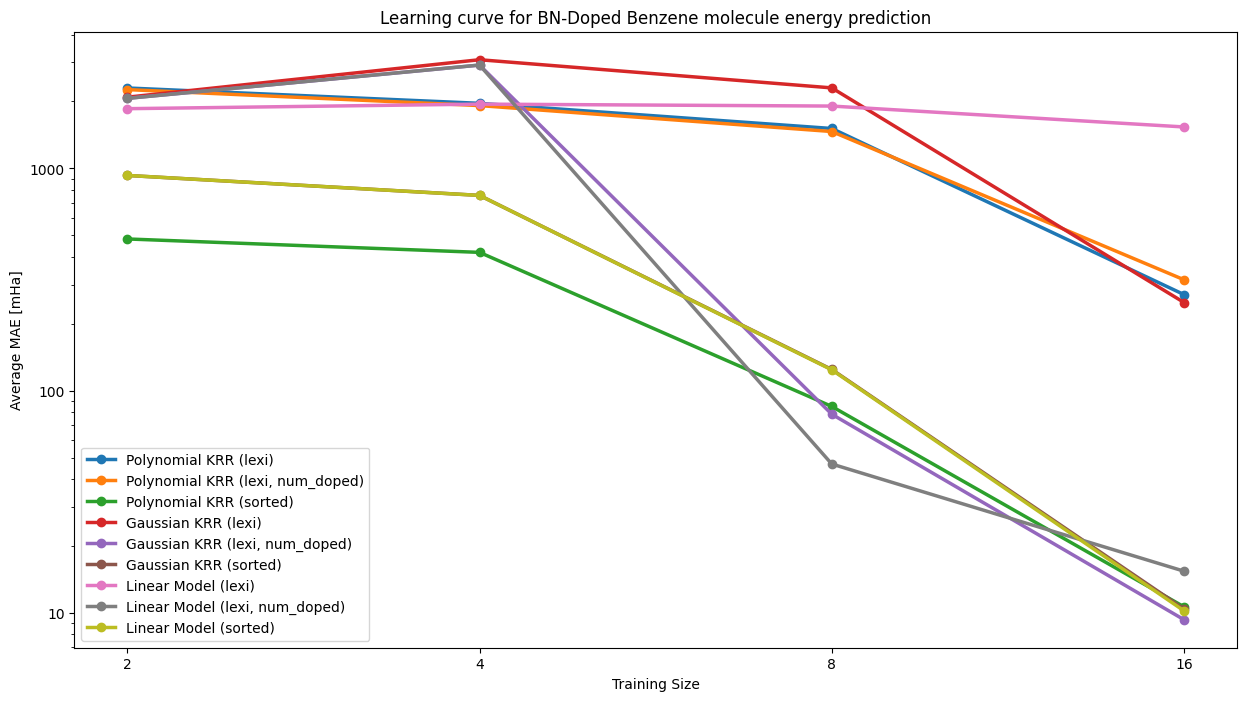

In [136]:
# No error bar
# Set figure size
plt.figure(figsize=(15, 8))

# Load the data
x = model_performance_poly_lexi_delta_tot['training size']

y1 = model_performance_poly_lexi_delta_tot['average MAE (mHa)']
y2 = model_performance_poly_lexi_nd_delta_tot['average MAE (mHa)']
y3 = model_performance_poly_sorted_delta_tot['average MAE (mHa)']

y4 = model_performance_gaussian_lexi_delta_tot['average MAE (mHa)']
y5 = model_performance_gaussian_lexi_nd_delta_tot['average MAE (mHa)']
y6 = model_performance_gaussian_sorted_delta_tot['average MAE (mHa)']

y7 = model_performance_linear_lexi_delta_tot['average MAE (mHa)']
y8 = model_performance_linear_lexi_nd_delta_tot['average MAE (mHa)']
y9 = model_performance_linear_sorted_delta_tot['average MAE (mHa)']

# Plotting
plt.plot(x, y1, label='Polynomial KRR (lexi)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y2, label='Polynomial KRR (lexi, num_doped)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y3, label='Polynomial KRR (sorted)', marker='o', linestyle='-', linewidth=2.5)

plt.plot(x, y4, label='Gaussian KRR (lexi)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y5, label='Gaussian KRR (lexi, num_doped)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y6, label='Gaussian KRR (sorted)', marker='o', linestyle='-', linewidth=2.5)

plt.plot(x, y7, label='Linear Model (lexi)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y8, label='Linear Model (lexi, num_doped)', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y9, label='Linear Model (sorted)', marker='o', linestyle='-', linewidth=2.5)

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average MAE [mHa]')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=10)

xticks = [2**i for i in range(1, 5)]
yticks = [10**i for i in range(1, 4)]
plt.xticks(xticks, labels = xticks)
plt.yticks(yticks, labels = yticks)


# Display the plot
plt.savefig('../Graph/[Benz] learning_curve_4_points_no_err_bar.png', dpi=300)
plt.show()


In [ ]:
# With Error Bar
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']
y3 = model_performance_ridge_regression['average RMSE']
y1_error = model_performance_poly_KRR['standard deviation']
y2_error = model_performance_gaussian_KRR['standard deviation']
y3_error = model_performance_ridge_regression['standard deviation']

# Plotting
# plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
# plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)
# plt.plot(x, y3, label='Ridge Regression', marker='o', linestyle='-', linewidth=2.5)
plt.errorbar(x, y1, label='Polynomial KRR', yerr=y1_error, marker='o', linestyle='-', capsize=3)
plt.errorbar(x, y2, label='Gaussian KRR', yerr=y2_error, marker='o', linestyle='-', capsize=3)
plt.errorbar(x, y3, label='Ridge Regression', yerr=y3_error, marker='o', linestyle='-', capsize=3)

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule energy prediction')
plt.xlabel('Training Size (log)')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=2)

# yticks = [2**i for i in range(-4, 7)]
yticks = [2**i for i in range(0, 7)]
plt.yticks(yticks, labels = yticks)

# Display the plot
plt.savefig('../Graph/[Benz] learning_curve_16_points_with_err_bar.png', dpi=300)
plt.show()


In [ ]:
# Plot a version without polynomial KRR, which performed the worst

plt.figure(figsize=(10, 6))

x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']
y3 = model_performance_ridge_regression['average RMSE']
y2_error = model_performance_gaussian_KRR['standard deviation']
y3_error = model_performance_ridge_regression['standard deviation']

plt.errorbar(x, y2, label='Gaussian KRR', yerr=y2_error, marker='o', linestyle='-', capsize=3)
plt.errorbar(x, y3, label='Ridge Regression', yerr=y3_error, marker='o', linestyle='-', capsize=3)

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule energy prediction')
plt.xlabel('Training Size (log)')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log', base=2)

yticks = [2**i for i in range(0, 3)]
plt.yticks(yticks, labels = yticks)

# Display the plot
plt.savefig('../Graph/[Benz] learning_curve_without_poly_KRR.png', dpi=300)
plt.show()

### Comparing to Prediction ###

In [ ]:
# Create a dataframe that contains the energies predicted by the model and the actual energy

# Specifies the columns of the dataframe and create an empty dataframe
columns = ['Elements', 'Poly KRR prediction', 'Gaussian KRR prediction', 'Ridge regression prediction', 'Actual energy']
model_prediction = pd.DataFrame(columns=columns)

# fill in elements and the actual energy values from the original benzene_data dataframe
model_prediction['Elements'] = benzene_data['Elements']
model_prediction['Actual energy'] = benzene_data['Energy']

# fit the gaussian KRR and ridge regression model on the training set
gaussian_KRR_model.fit(X, y)
ridge_model.fit(X, y)
poly_KRR_model.fit(X, y)

# iterate through each row entry of the data
for index, row in model_prediction.iterrows():
    x_pred = X.loc[[index]] # extract the input to be predicted
    
    # predict energy using the two models
    # the given prediction is in a list of one element. use [0] to extract the actual value
    gaussian_prediction = gaussian_KRR_model.predict(x_pred)[0] 
    ridge_prediction = ridge_model.predict(x_pred)[0]
    poly_prediction = poly_KRR_model.predict(x_pred)[0] 
    
    # Record the prediction in the DataFrame
    model_prediction.at[index, 'Poly KRR prediction'] = poly_prediction
    model_prediction.at[index, 'Gaussian KRR prediction'] = gaussian_prediction
    model_prediction.at[index, 'Ridge regression prediction'] = ridge_prediction

# display the data
display(model_prediction)


In [ ]:
# Graph the results

plt.figure(figsize=(10, 6))

x = [i for i in range(17)]
y_pred_1 = model_prediction['Gaussian KRR prediction']
y_pred_2 = model_prediction['Ridge regression prediction']
y_pred_3 = model_prediction['Poly KRR prediction']
y = model_prediction['Actual energy']

plt.plot(x, y_pred_1, label='Gaussian KRR prediction', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y_pred_2, label='Ridge regression prediction', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y_pred_3, label='Poly KRR prediction', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y, label='Actual energy', marker='o', linestyle='-', linewidth=2.5)

plt.title('Comparing model prediction with actual energy')
plt.xlabel('Element index')
plt.ylabel('Energy [Ha]')
plt.legend()

yticks = np.linspace(-230, -240, num=11)
plt.yticks(yticks, labels = yticks)

plt.savefig('../Graph/[Benz] comparing_model_performance.png', dpi=300)
plt.show()
